## 1. Installing Huggingface and importing all relevant packages for the analysis

In [6]:
# Installing the latest Huggingface library to load different pre-trained attention-based language models

!pip install transformers==4.11.3
!pip install torch==1.10.2

     |████████████████████████████████| 2.9 MB 14.0 MB/s 
     |████████████████████████████████| 895 kB 62.4 MB/s 
     |████████████████████████████████| 3.3 MB 66.9 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:43tcmalloc: large alloc 1147494400 bytes == 0x5580b13f6000 @  0x7f399c837615 0x55804c58a3bc 0x55804c66b18a 0x55804c58d1cd 0x55804c67fb3d 0x55804c601458 0x55804c5fc02f 0x55804c58eaba 0x55804c6012c0 0x55804c5fc02f 0x55804c58eaba 0x55804c5fdcd4 0x55804c680986 0x55804c5fd350 0x55804c680986 0x55804c5fd350 0x55804c680986 0x55804c5fd350 0x55804c58ef19 0x55804c5d2a79 0x55804c58db32 0x55804c6011dd 0x55804c5fc02f 0x55804c58eaba 0x55804c5fdcd4 0x55804c5fc02f 0x55804c58eaba 0x55804c5fceae 0x55804c58e9da

In [8]:
import dill
import glob
import json
import os
import time

from sklearn import preprocessing
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import tqdm
from transformers import RobertaModel, RobertaTokenizer



## 2. Loading & tokenizing ACL-ARC dataset from raw jsonl files for fine-tuning the pre-trained language model
  - Number of training documents: 1,688
  - Number of test documents: 139
  - Number of classes: 6

In [10]:
TRAIN_PATH = "/content/drive/MyDrive/CS699/data/ACL-ARC_train.jsonl"
TEST_PATH = "/content/drive/MyDrive/CS699/data/ACL-ARC_test.jsonl"

def load_json(json_path, text_key='text', label_key='label'):
  X = []
  Y = []
  with open(json_path, 'r') as f:
    for line in f:
      raw_json = json.loads(line)
      X.append(raw_json[text_key])
      Y.append(raw_json[label_key])
  return X, Y

trainX, trainY = load_json(TRAIN_PATH)
testX, testY = load_json(TEST_PATH)
num_classes = len(set(trainY))

print("# of total sentences:", len(trainX), len(testX))
print("An example sentence:", trainX[2])
print('# of labels:', num_classes)

# of total sentences: 1688 139
An example sentence: She evaluates 3,000 German verbs with a token frequency between 10 and 2,000 against the Duden ( Dudenredaktion 2001 ) .
# of labels: 6


- For all cases, the raw text data will be tokenized and encoded by RoBERTa tokenizer provided in Huggingface
- RoBERTa tokenizer uses a Byte-Pair encoding on 50K subword units
- All of the sentences are either padded or truncated to contain 512 tokens to match the output dimensions of RoBERTa

In [11]:
def convert_txt2tokenid(tokenizer, text):
  token_ids = []
  for sent in text:
    token_ids.append(tokenizer.encode(sent, padding='max_length', return_tensors = 'pt'))
  return torch.cat(token_ids, dim=0)

roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

encoded_trainX = convert_txt2tokenid(roberta_tokenizer, trainX)
encoded_testX = convert_txt2tokenid(roberta_tokenizer, testX)

label_encoder = preprocessing.LabelEncoder()

encoded_trainY = label_encoder.fit_transform(trainY)
encoded_testY = label_encoder.transform(testY)

encoded_trainY = torch.tensor(encoded_trainY)
encoded_testY = torch.tensor(encoded_testY)

print(encoded_trainX[0])
print(encoded_trainY[0])

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

tensor([    0, 42702,  2156,    81,     5,   375,   367,   107,  2156,   552,
           19,  9766,    11,     5,   304,     9,  2239,     8, 17325,  6448,
           13,  3857,     9,   455, 28564,   268,    36,  5415,  2156,  7528,
        25606,   732,  4422, 20082,  2156,  7528,   102, 25606,   732,  4422,
        20082,  2156,  7528,   428, 25606, 12041,   282,  1115,  3994,  3592,
         2156,  7528,  4839,  2156,  1233,  2017,    34,    57,   156,    15,
            5,   304,     9, 17325,  2239,  6448,     7,  5281, 16762, 46563,
         8117, 45774, 28201, 22810,    50,  1617,    14,  4064,    11,    10,
        45774, 28201,  1291,    36,  2197,  2156, 11151, 25606,  3513, 18086,
            8,  7380,  2156,  7969, 25606, 19021, 22704,  4400,  1076,     4,
         2156,  6708, 25606,  5866,   324,     8, 13891,  2156,  6708, 25606,
         6760,  3979,  4400,  1076,     4,  2156,  6193, 25606, 14687,   219,
          677,   260,  1638,     8, 13880,  2156,  5155, 25606, 

- The encoded training and test datasets created as PyTorch dataloaders
- Batch size set as 16 as indicated in 'Don't Stop Pretraining' paper

In [12]:
batch_size = 16
torch.manual_seed(42)

train_dataset = TensorDataset(encoded_trainX, encoded_trainY)
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

test_dataset = TensorDataset(encoded_testX, encoded_testY)
test_dataloader = DataLoader(
            test_dataset,
            sampler = RandomSampler(test_dataset),
            batch_size = batch_size
        )

## 3. Creating RoBERTa model for document classification
- On top of RoBERTa, a single feedforward layer for classification is added
- Once again, hyperparameters of this additional feedforward layer is set and as described in "Don't Stop Pretraining" paper (Table 14)
  - Number of epochs: 10
  - Learning rate of Adam: 2e-5
  - Dropout: 0.1
  - Feedforwad nonlinearity: tanh

In [13]:
# RobertaForSequenceClassification could also be used.
# Drop out rate as used in the paper
class CustomRoberta(nn.Module):
    def __init__(self, num_classes = num_classes):
          super(CustomRoberta, self).__init__()
          self.robert = RobertaModel.from_pretrained("roberta-base", output_attentions = True, output_hidden_states = True)
          self.linear = nn.Linear(768, 768)
          self.classification = nn.Linear(768,num_classes)
          self.dropout = nn.Dropout(0.1)
          self.activation = nn.Tanh()

    def forward(self, ids):
          # index 1 represents the pooled_output, the cls token.
          sequence_output = self.robert(ids)[1]
          
          dropout = self.dropout(sequence_output)
          linear_output = self.linear(dropout)
          temp = self.activation(linear_output)
          output = self.classification(temp)

          return output

model = CustomRoberta(num_classes = num_classes)
model.cuda()

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomRoberta(
  (robert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

- Loading all of Umang's template codes necessary for projections

In [16]:
def count_params(model: torch.nn.Module, skip_bn_bias=False):
    count = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                count += param.numel()
    return count

def flatten_grads(model, num_params, skip_bn_bias=False):
    flat_grads = torch.zeros(num_params, requires_grad=False)
    idx = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                flat_grads[idx:idx + param.numel()] = torch.flatten(param.grad).data.cpu()
                idx += param.numel()
    return flat_grads

def get_loss_value(model, loader, device, cal_f1=True):
    """
    Evaluation loop for the multi-class classification problem.
    return (loss, accuracy)
    """
    model.eval()
    losses = []
    accuracies = []
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels, reduce=None).detach()
            losses.append(loss.reshape(-1))
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == labels).float().detach()
            pred_labels+=preds.detach().cpu().tolist()
            true_labels+=labels.detach().cpu().tolist()
            accuracies.append(acc.reshape(-1))

        losses = torch.cat(losses, dim=0).mean().cpu().data.numpy()
        accuracies = torch.cat(accuracies, dim=0).mean().cpu().data.numpy()
        if cal_f1:
          p_macro, r_macro, f1_macro, support_macro = \
                  precision_recall_fscore_support(y_true=np.array(true_labels), y_pred=np.array(pred_labels), average='macro')
          return losses, accuracies, p_macro, r_macro, f1_macro
        else:
          return losses, accuracies


def flatten_params(model, num_params, skip_bn_bias=False):
    flat_param = torch.zeros(num_params, requires_grad=False)
    idx = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                flat_param[idx:idx + param.numel()] = torch.flatten(param).data.cpu()
                idx += param.numel()
    return flat_param

def set_weights_by_direction(model, x, y, direction1, direction2, weights, skip_bn_bias=False):
    if direction2 is not None:
        changes = direction1 * x + direction2 * y
    else:
        changes = direction1 * x

    apply_params(model, weights + changes, skip_bn_bias=skip_bn_bias)

def apply_params(model, array, skip_bn_bias=False):
    idx = 0
    for param in model.parameters():
        if param.requires_grad:
            if param.dim() <= 1 and skip_bn_bias:
                pass
            else:
                param.data = (array[idx:idx + param.numel()]).reshape(param.data.shape)
                idx += param.numel()
    return model


## Fine-tuning RoBERTa on ACL-ARC classification while performing frequent direction algorithm during the training

In [ ]:
epochs = 10
optimizer = Adam(model.parameters(), lr = 2e-5)

RESULT_FOLDER = "/content/drive/MyDrive/CS699/data/ROBERTA/"
os.makedirs(f"{RESULT_FOLDER}/new_ckpt", exist_ok=True)

device = torch.device("cuda")
total_params = count_params(model, skip_bn_bias=True)
t0 = time.time()

for epoch in range(epochs):
  model.train()
  epoch_start = time.time()

  for i, batch in enumerate(train_dataloader):

    d_input_id = batch[0].to(device)
    d_labels = batch[1].to(device)
    outputs = model(d_input_id)
    loss = torch.nn.functional.cross_entropy(outputs, d_labels)

    model.zero_grad()
    loss.backward()
    optimizer.step()


  loss, acc, prec, recall, f1 = get_loss_value(model, test_dataloader, device=device)

  print("For epoch #%d: took %f seconds" %(epoch+1, time.time()-epoch_start)) 
  print("\t Loss: %f, Accuracy on the test dataset: %f" %(loss, acc))
  print("\t prec: %f, recall: %f, macro f1: %f" %(prec, recall, f1))
  
  torch.save(
      model.state_dict(), f'{RESULT_FOLDER}/new_ckpt/{epoch + 1}_model.pt',
      pickle_module=dill
  )

training_time = time.time() - t0
print("The entire training took: %f" %(training_time))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #1: took 51.372868 seconds
	 Loss: 1.365418, Accuracy on the test dataset: 0.510791
	 prec: 0.085132, recall: 0.166667, macro f1: 0.112698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #2: took 51.401585 seconds
	 Loss: 1.338998, Accuracy on the test dataset: 0.510791
	 prec: 0.085132, recall: 0.166667, macro f1: 0.112698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #3: took 51.401643 seconds
	 Loss: 1.330309, Accuracy on the test dataset: 0.510791
	 prec: 0.085132, recall: 0.166667, macro f1: 0.112698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #4: took 51.429361 seconds
	 Loss: 1.170004, Accuracy on the test dataset: 0.582734
	 prec: 0.184783, recall: 0.275460, macro f1: 0.219922


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #5: took 51.416995 seconds
	 Loss: 1.020666, Accuracy on the test dataset: 0.633094
	 prec: 0.254080, recall: 0.304594, macro f1: 0.268340


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For epoch #6: took 51.465899 seconds
	 Loss: 0.861938, Accuracy on the test dataset: 0.719424
	 prec: 0.421717, recall: 0.492030, macro f1: 0.444320
For epoch #7: took 51.420917 seconds
	 Loss: 0.883852, Accuracy on the test dataset: 0.748201
	 prec: 0.652896, recall: 0.555149, macro f1: 0.573128
For epoch #8: took 51.454712 seconds
	 Loss: 0.849078, Accuracy on the test dataset: 0.755396
	 prec: 0.698880, recall: 0.635586, macro f1: 0.644281
For epoch #9: took 51.440423 seconds
	 Loss: 0.900752, Accuracy on the test dataset: 0.776978
	 prec: 0.704036, recall: 0.676792, macro f1: 0.683498
For epoch #10: took 51.430394 seconds
	 Loss: 0.881596, Accuracy on the test dataset: 0.741007
	 prec: 0.612327, recall: 0.642841, macro f1: 0.621454
The entire training took: 528.962056


## Computing directions for projections
- Random direction [O]
- PCA [O] - works with incremental PCA
- In-training SVD [X]

In [ ]:
import logging

import dill
import numpy
from sklearn.decomposition import IncrementalPCA
from torch import nn

logger = logging.getLogger()

def get_PCA_directions(model: nn.Module, state_files, skip_bn_bias):
    """
        Compute PCA direction as defined in Li et al. 2017 (https://arxiv.org/abs/1712.09913)
    :param model: model object
    :param state_files: list of checkpoints.
    :param skip_bn_bias: Skip batch norm and bias while flattening the model params. Li et al. do not use batch norm and bias parameters
    :return: (pc1, pc2, explained variance)
    """

    # load final weights and flatten
    print("Loading: %s" %(state_files[-1]))
    model.load_state_dict(torch.load(state_files[-1], pickle_module=dill, map_location="cpu"))
    total_param = count_params(model, skip_bn_bias=skip_bn_bias)
    print(total_param)
    w_final = flatten_params(model, total_param, skip_bn_bias=skip_bn_bias)

    # compute w_i- w_final
    w_diff_matrix = numpy.zeros((len(state_files) - 1, total_param))
    for idx, file in enumerate(state_files[:-1]):
        print(file)
        model.load_state_dict(torch.load(file, pickle_module=dill, map_location="cpu"))
        w = flatten_params(model, total_param, skip_bn_bias=skip_bn_bias)

        diff = w - w_final
        w_diff_matrix[idx] = diff
        del w
        del diff

    # Perform PCA on the optimization path matrix
    logger.info("Perform PCA on the models")
    print("Performing PCA")

    # Due to the memory issue, traditional PCA has been replaced by incremental PCA, 
    # in which the matrix decomposition is done in a batch a
    pca = IncrementalPCA(n_components=2)
    pca.fit(w_diff_matrix)
    pc1 = numpy.array(pca.components_[0])
    pc2 = numpy.array(pca.components_[1])
    print(
        f"angle between pc1 and pc2: {numpy.dot(pc1, pc2) / (numpy.linalg.norm(pc1) * numpy.linalg.norm(pc2))}"
    )
    print(f"pca.explained_variance_ratio_: {pca.explained_variance_ratio_}")
    print(f"pca singular values: {pca.singular_values_}")

    return pc1, pc2, pca.explained_variance_ratio_

In [ ]:
import glob
import os

import numpy

CHECKPOINTS_FILES = glob.glob("/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/*")
DIRECTION_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"
FILE_NAME = 'pca_directions.npz'

os.makedirs(f"{DIRECTION_DIR}", exist_ok=True)

direction1, direction2, ex_var = get_PCA_directions(model, CHECKPOINTS_FILES, True)

numpy.savez(
    f"{DIRECTION_DIR}/{FILE_NAME}", explained_variance=ex_var,
    direction2=direction2, direction1=direction1
)


Loading: /content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/10_model.pt
125117952
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/1_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/2_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/3_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/4_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/5_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/6_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/7_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/8_model.pt
/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/9_model.pt
Performing PCA
angle between pc1 and pc2: -2.4806545706468356e-16
pca.explained_variance_ratio_: [0.70666966 0.14283133]
pca singular values: [9.64599941 4.33661375]


## Computing trajectories

In [ ]:
import dill
import glob

import torch
import numpy

CHECKPOINTS_FILES = glob.glob("/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/*")
DIRECTION_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"
FILE_NAME = 'pca_directions.npz'

temp = numpy.load(DIRECTION_DIR+FILE_NAME)
direction1 = torch.tensor(temp["direction1"], device="cpu").float()
direction2 = torch.tensor(temp["direction2"], device="cpu").float()

model.load_state_dict(torch.load(CHECKPOINTS_FILES[-1], pickle_module=dill, map_location="cpu"))
total_param = count_params(model, skip_bn_bias=True)
w_final = flatten_params(model, total_param, skip_bn_bias=True)

w_diff_matrix = torch.zeros(len(CHECKPOINTS_FILES) - 1, total_param)
for idx, file in enumerate(CHECKPOINTS_FILES[:-1]):
    model.load_state_dict(torch.load(file, pickle_module=dill, map_location="cpu"))
    w = flatten_params(model, total_param, skip_bn_bias=True)

    diff = w - w_final
    w_diff_matrix[idx] = diff

if torch.isclose(direction1 @ direction2, torch.tensor(0.0)):
    logger.info("The directions are orthogonal")
    # when dx and dy are orthorgonal
    xcoords = w_diff_matrix @ direction1 / direction1.norm()
    ycoords = w_diff_matrix @ direction2 / direction2.norm()
else:
    # w_diff (nxd)
    # A = dx2
    # X = 2xn
    # AX = w_diff.T
    # solve the least squre problem: Ax = d
    A = torch.vstack([direction1, direction2]).T  # num_param X 2
    temp = torch.linalg.lstsq(A, w_diff_matrix.T).solution  # 2
    xcoords, ycoords = temp[0], temp[1]

In [ ]:
PROJECTION_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"
FILE_NAME = 'pca_dir_proj.npz'

os.makedirs(f"{PROJECTION_DIR}", exist_ok=True)

numpy.savez(
    f"{PROJECTION_DIR}/{FILE_NAME}", xcoordinates=xcoords.cpu().data.numpy(),
    ycoordinates=ycoords.cpu().data.numpy()
)

## Computing the loss landscape of the final model

In [ ]:
import glob

CHECKPOINTS_FILES = glob.glob("/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/*")
DIRECTION_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"

In [ ]:
import dill
import numpy
from tqdm import tqdm

device = torch.device("cuda")
xcoords = "20:-20:20" 
ycoords = "20:-20:20"
print("Loading: %s" %(CHECKPOINTS_FILES[-1]))
state_dict = torch.load(CHECKPOINTS_FILES[-1], pickle_module=dill, map_location=device)
model.load_state_dict(state_dict)

total_params = count_params(model, skip_bn_bias=True)
pretrained_weights = flatten_params(model, num_params=total_params, skip_bn_bias=True).to(device)

temp = numpy.load(DIRECTION_DIR+"pca_directions.npz")
direction1 = torch.tensor(temp["direction1"], device=device).float()
direction2 = torch.tensor(temp["direction2"], device=device).float()

x_num, x_min, x_max = [float(i) for i in xcoords.split(":")]
y_num, y_min, y_max = [float(i) for i in ycoords.split(":")]

x_num, y_num = int(x_num), int(y_num)

print(f"x-range: {x_min}:{x_max}:{x_num}")
print(f"y-range: {y_min}:{y_max}:{y_num}")

xcoordinates = numpy.linspace(x_min, x_max, num=x_num)
print(xcoordinates)
ycoordinates = numpy.linspace(y_min, y_max, num=y_num)
print(ycoordinates)

losses = numpy.zeros((x_num, y_num))
accuracies = numpy.zeros((x_num, y_num))

with tqdm(total=x_num * y_num) as pbar:
    for idx_x, x in enumerate(xcoordinates):
        for idx_y, y in enumerate(ycoordinates):
            # import ipdb;ipdb.set_trace()
            set_weights_by_direction(
                model, x, y, direction1, direction2, pretrained_weights,
                skip_bn_bias=True
            )
            losses[idx_x, idx_y], accuracies[idx_x, idx_y] = get_loss_value(
                model, train_dataloader, device, cal_f1=False
            )
            pbar.set_description(f"x:{x: .4f}, y:{y: .4f}, loss:{losses[idx_x, idx_y]:.4f}")
            pbar.update(1)

Loading: /content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/10_model.pt
x-range: -20.0:20.0:20
y-range: -20.0:20.0:20
[-20.         -17.89473684 -15.78947368 -13.68421053 -11.57894737
  -9.47368421  -7.36842105  -5.26315789  -3.15789474  -1.05263158
   1.05263158   3.15789474   5.26315789   7.36842105   9.47368421
  11.57894737  13.68421053  15.78947368  17.89473684  20.        ]
[-20.         -17.89473684 -15.78947368 -13.68421053 -11.57894737
  -9.47368421  -7.36842105  -5.26315789  -3.15789474  -1.05263158
   1.05263158   3.15789474   5.26315789   7.36842105   9.47368421
  11.57894737  13.68421053  15.78947368  17.89473684  20.        ]


x: 20.0000, y: 20.0000, loss:5.1057: 100%|██████████| 400/400 [1:47:09<00:00, 16.07s/it]


In [ ]:
import os 

LOSS_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"
LOSS_NAME = 'pca_dir_loss_surface_m20p20c20.npz'

os.makedirs(f"{LOSS_DIR}", exist_ok=True)

numpy.savez(
    f"{LOSS_DIR}/{LOSS_NAME}", losses=losses, accuracies=accuracies,
    xcoordinates=xcoordinates, ycoordinates=ycoordinates
)


## Plotting results

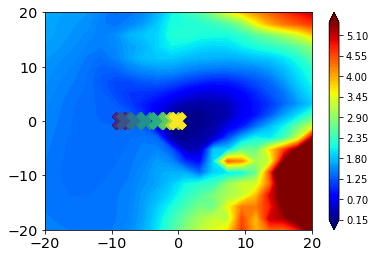

In [1]:
import numpy
from matplotlib import pyplot

LOSS_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"
LOSS_NAME = 'pca_dir_loss_surface_m20p20c20.npz'

PROJECTION_DIR = "/content/drive/MyDrive/CS699/data/ROBERTA/"
FILE_NAME = 'pca_dir_proj.npz'

data = numpy.load(f"{LOSS_DIR + LOSS_NAME}")

xcoords = data["xcoordinates"]
ycoords = data["ycoordinates"]
losses = data["losses"]
acc = data["accuracies"]

X, Y = numpy.meshgrid(xcoords, ycoords, indexing="ij")
Z = losses
fig = pyplot.figure()
CS = pyplot.contourf(X, Y, Z, cmap='jet', levels=numpy.arange(0.15, 5.5, 0.05), extend='both')
#pyplot.clabel(CS, inline=1, fontsize=8)

data = numpy.load(PROJECTION_DIR+FILE_NAME)

xcoords = data["xcoordinates"]
ycoords = data["ycoordinates"]
#pyplot.plot(xcoords, ycoords, linewidth=10, alpha=0.3)
pyplot.colorbar()
pyplot.scatter(xcoords, ycoords, s=300, marker='X', c=numpy.arange(len(xcoords)))
pyplot.tick_params('y', labelsize='x-large')
pyplot.tick_params('x', labelsize='x-large')



In [ ]:
Z.min(), Z.max()

(0.1723347157239914, 10.022488594055176)

In [4]:
data['xcoordinates']

array([-8.604961  , -8.493507  , -7.922897  , -6.416379  , -4.8814063 ,
       -3.1080523 , -1.61194   , -0.63149494, -0.12025006], dtype=float32)

In [ ]:
fig.savefig(
    f"/content/drive/MyDrive/CS699/data/ROBERTA/roberta_pca_contourf", dpi=300,
    bbox_inches='tight'
)

## Computing F1 Score

In [14]:
CHECKPOINTS_FILES = glob.glob("/content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/*")
model.load_state_dict(torch.load(CHECKPOINTS_FILES[-1], pickle_module=dill, map_location="cuda"))
print("\tLoaded: %s" %(CHECKPOINTS_FILES[-1]))

	Loaded: /content/drive/MyDrive/CS699/data/ROBERTA/new_ckpt/10_model.pt


In [19]:
  loss, acc, prec, recall, f1 = get_loss_value(model, train_dataloader, device='cuda')

  print("\t Loss: %f, Accuracy on the train dataset: %f" %(loss, acc))
  print("\t prec: %f, recall: %f, macro f1: %f" %(prec, recall, f1))

	 Loss: 0.175168, Accuracy on the train dataset: 0.951422
	 prec: 0.900241, recall: 0.936604, macro f1: 0.917064
